# Лабораторная работа №4. Семантическая сегментация изображений
Реализация модели сверточной нейронной сети для классификации пикселей, принадлежащих объектам.
В работе используется датасет COCO, расположенный по ссылке http://cocodataset.org/.
Модель натренирована классифицировать пиксели принадлежащие машинам, мотоциклам, самолетам, автобусам и поездам.
В качестве энкодера нейронной сети взята FPN с энкодером Resnet50.
Loss-функция - категориальная кросс-энтропия (categorical cross entropy).
Метрика - точность (accuracy).

## Задача
1. Натренировать сеть для классификации животных из датасета COCO. (10 классов + класс фона).
2. Перепишите класс Dataset. Добавьте легкую аугментацию изображений: зеркалирование изображения относительно вертикальной оси, случайная обрезка кадра.
3. Дописать код, чтобы при обучении давать оценку точности, полноты и F-меры для каждого класса модели. Информацию можно получить по ссылке https://habr.com/ru/company/ods/blog/328372/.

На основании точности, полноты и F-меры для каждого класса сделайте выводы о качестве построенной модели.

In [1]:
from torch.utils.data import DataLoader
from torchvision.datasets import CocoCaptions, CocoDetection
from torchvision import transforms
from pycocotools import mask
import numpy as np
import segmentation_models_pytorch as smp
from datetime import datetime
import torch
from torch.utils import data
from PIL import Image
from albumentations import (
    RandomSizedCrop,
    HorizontalFlip,
    Compose, 
    PadIfNeeded)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# augmentation example

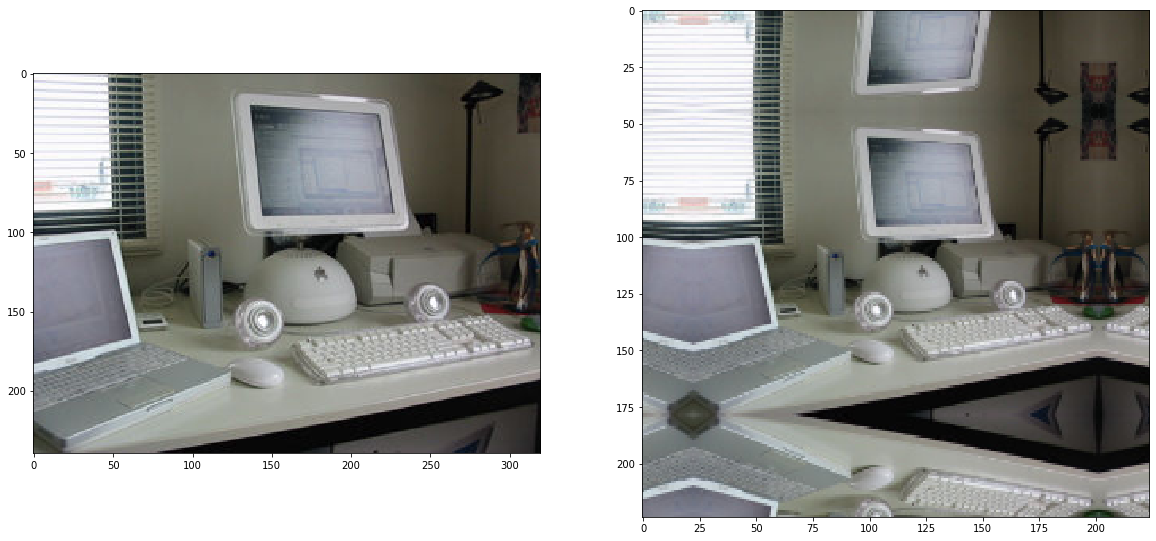

In [3]:
img1 = Image.open('/home/euloo/Documents/datasets/coco2017/val2017/000000001503.jpg') # маленькое изображение

img1 = np.float32(np.array(img1)) / 255.
aug = Compose([PadIfNeeded(min_height=400, min_width=400), 
               RandomSizedCrop(min_max_height=(400, 400), height=224, width=224, p=1),
               HorizontalFlip(p=0.5)])
augmented = aug(image=img1)
img2 = augmented['image']


plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img1)
plt.subplot(122)
plt.imshow(img2)
plt.show()

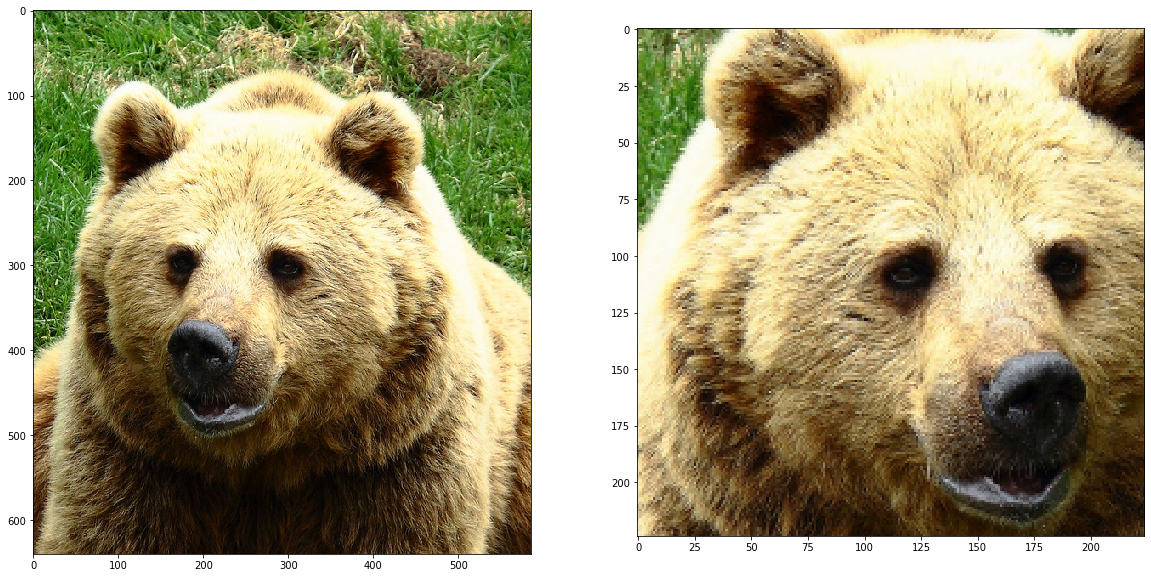

In [4]:
img1 = Image.open('/home/euloo/Documents/datasets/coco2017/val2017/000000000285.jpg') # большое изображение
img1 = np.float32(np.array(img1)) / 255.
aug = Compose([PadIfNeeded(min_height=400, min_width=400), 
               RandomSizedCrop(min_max_height=(400, 400), height=224, width=224, p=1),
               HorizontalFlip(p=0.5)])
augmented = aug(image=img1)
img2 = augmented['image']


plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img1)
plt.subplot(122)
plt.imshow(img2)
plt.show()

Реализация класса Dataset с чтением изображений и аннотаций в виде масок для тренировочного и валидационного датасетов.

In [5]:
class Dataset(CocoDetection):
    def __init__(self, root, annFile, subset='train', train_part=0.8):
        super().__init__(root, annFile, transforms=None, transform=None, target_transform=None)
        
        cat_names = ['bird',
                     'dog',
                     'sheep',
                     'elephant',
                     'zebra',
                     'giraffe',
                     'bear',
                     'cow',
                     'horse',
                     'cat'
                    ]
        
        cats = self.coco.loadCats(self.coco.getCatIds(cat_names))
        
        ids = []
        self.id_to_class, self.class_to_name = dict(), dict()
        self.id_to_class[0] = 0
        self.class_to_name[0] = 'background'
        for it, cat in enumerate(cats):
            self.id_to_class[cat['id']] = it+1
            self.class_to_name[it+1] = cat['name']
            
            ids.append(self.coco.getImgIds(catIds=[cat['id']]))
        self.ids = sum(ids, [])
        np.random.seed(1)
        np.random.shuffle(self.ids)
        if subset == 'train':
            self.ids = self.ids[:int(len(self.ids) * train_part)]
        elif subset == 'valid':
            self.ids = self.ids[int(len(self.ids) * train_part):]
            
    def num_classes(self):
        return len(self.id_to_class)
    
        
    def __getitem__(self, index):

        img, ann = super().__getitem__(index)
        width, height = img.size[:2]

        msk = np.zeros((height, width), dtype=np.uint8)
        for i, it in enumerate(ann):
            if it['category_id'] in self.id_to_class.keys():
                compressed_rle = mask.frPyObjects(it['segmentation'], height, width)
                bw = mask.decode(compressed_rle)

                if len(bw.shape) == 3:
                    bw = np.sum(bw, axis=2)

                msk[np.where(bw != 0)] = self.id_to_class[it['category_id']]
        
        
        img = np.float32(np.array(img)) / 255.
        msk = np.array(msk)
        aug = Compose([PadIfNeeded(min_height=400, min_width=400), 
               RandomSizedCrop(min_max_height=(400, 400), height=224, width=224, p=1),
               HorizontalFlip(p=0.5)])
        augmented = aug(image=img, mask=msk)
        img = augmented['image']
        msk = augmented['mask']
        

        img = img.transpose((2, 0, 1))
        img = torch.from_numpy(img.copy())
        msk = torch.from_numpy(np.array(msk)).long()
              
        return img, msk, ann
    
    
    
    

Создаем объекты класса Dataset для тренировки и валидации.

In [6]:
path_to_images = '/home/euloo/Documents/datasets/coco2017/train2017'
#path_to_images = '/home/euloo/Documents/datasets/coco2017/val2017'
path_to_anno = '/home/euloo/Documents/datasets/coco2017/annotations/instances_train2017.json'
#path_to_anno = '/home/euloo/Documents/datasets/coco2017/annotations/instances_val2017.json'
train_dataset = Dataset(path_to_images, path_to_anno, subset='train')
valid_dataset = Dataset(path_to_images, path_to_anno, subset='valid')

loading annotations into memory...
Done (t=18.05s)
creating index...
index created!
loading annotations into memory...
Done (t=19.31s)
creating index...
index created!


In [7]:
train_dataset.class_to_name

{0: 'background',
 1: 'bird',
 2: 'cat',
 3: 'dog',
 4: 'horse',
 5: 'sheep',
 6: 'cow',
 7: 'elephant',
 8: 'bear',
 9: 'zebra',
 10: 'giraffe'}

In [8]:
len(train_dataset), len(valid_dataset)

(20591, 5148)

Визуализируем результаты изображения и маски.

In [9]:
img, msk, ann = train_dataset[5]#5

In [10]:
for i in train_dataset.class_to_name:
    print(train_dataset.class_to_name[i], np.sum(msk.numpy() == i), ' pixels')

background 42811  pixels
bird 0  pixels
cat 7365  pixels
dog 0  pixels
horse 0  pixels
sheep 0  pixels
cow 0  pixels
elephant 0  pixels
bear 0  pixels
zebra 0  pixels
giraffe 0  pixels


### Иногда(!) вылетает эта ошибка 
~~~
:/home/euloo/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
~~~

/home/euloo/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


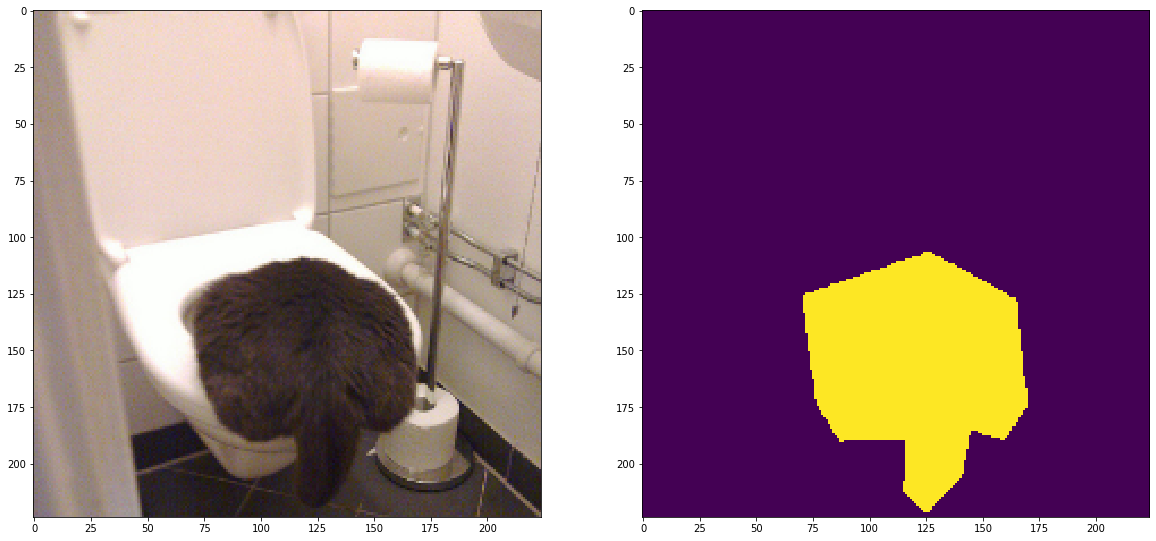

In [11]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(img.numpy().transpose((1,2,0)))
plt.subplot(122)
plt.imshow(np.squeeze(msk.numpy()))
plt.show()

Создаем загрузчики данных для тренировки.

In [12]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)

Создаем класс для рассчета и хранения средних значений величин. Далее будем таким образом считать средние значения функции потерь и метрик.

In [13]:
class AverageMeter(object):
    def __init__(self):
        self.initialized = False
        self.val = None
        self.avg = None
        self.sum = None
        self.count = None

    def initialize(self, val, weight):
        self.val = val
        self.avg = val
        self.sum = val * weight
        self.count = weight
        self.initialized = True

    def update(self, val, weight=1):
        if not self.initialized:
            self.initialize(val, weight)
        else:
            self.add(val, weight)

    def add(self, val, weight):
        #print("add val ", val, " weight " ,weight)
        self.val = val
        self.sum += val * weight
        self.count += weight
        self.avg = self.sum / self.count

    def value(self):
        return self.val

    def average(self):
        return self.avg

Создаем модели и определяем функцию потерь и метрики. Определяем шаги обучения.

In [14]:
#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
#y_pred = np.array([[0, 0, 1, 0, 0], [0, 2, 0, 0, 2], [3, 0, 0, 0, 0]])
#y_true = np.array([3, 3, 1, 0, 2])
#precision_score(y_true==1, y_pred[0]==1)

In [15]:
from torch import nn

model = smp.FPN(encoder_name='resnet50', classes=train_dataset.num_classes(), activation='softmax').to(device)

criterion = nn.CrossEntropyLoss()
criterion.__name__= 'loss'

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-4}, 

    {'params': model.encoder.parameters(), 'lr': 1e-5},  
])

- outputs = pred torch.Size([16, 11, 224, 224])
- masks = label torch.Size([16, 224, 224])
### TP TN FP FN 

In [16]:
def per_class_TP(preds, label): # совсем не уверена, что это правильно и вменяемо 🙈
    classes = []
    for i in train_dataset.class_to_name:
        valid = (label == i).long()
        TP = torch.sum(valid * (preds == label).long())
        classes.append(TP)
    return torch.stack(classes).float()

def per_class_TN(preds, label): 
    classes = []
    for i in train_dataset.class_to_name:
        valid = (label != i).long()
        TN = torch.sum(valid * (preds != label).long())
        classes.append(TN)
    return torch.stack(classes).float()

def per_class_FP(preds, label):
    classes = []
    for i in train_dataset.class_to_name:
        valid = (label != i).long()
        FP = torch.sum(valid * (preds == label).long())
        classes.append(FP)
    return torch.stack(classes).float()

def per_class_FN(preds, label):
    classes = []
    for i in train_dataset.class_to_name:
        valid = (label == i).long()
        FN = torch.sum(valid * (preds != label).long())
        classes.append(FN)
    return torch.stack(classes).float()

In [17]:
def pixel_acc(pred, label):
    _, preds = torch.max(pred, dim=1)
    valid = (label >= 0).long()
    acc_sum = torch.sum(valid * (preds == label).long())
    pixel_sum = torch.sum(valid)
    acc = acc_sum.float() / (pixel_sum.float() + 1e-10)
    return acc

# not use
"""
def per_class_pixel_acc_old(pred, label):
    
    _, preds = torch.max(pred, dim=1)
    acc_classes = []
    for i in train_dataset.class_to_name:
        valid = (label == i).long()
        acc_sum = torch.sum(valid * (preds == label).long())
        pixel_sum = torch.sum(valid)
        acc = acc_sum.float() / (pixel_sum.float() + 1e-10)
        acc_classes.append(acc.data.item())
    return acc_classes
"""

'\ndef per_class_pixel_acc_old(pred, label):\n    \n    _, preds = torch.max(pred, dim=1)\n    acc_classes = []\n    for i in train_dataset.class_to_name:\n        valid = (label == i).long()\n        acc_sum = torch.sum(valid * (preds == label).long())\n        pixel_sum = torch.sum(valid)\n        acc = acc_sum.float() / (pixel_sum.float() + 1e-10)\n        acc_classes.append(acc.data.item())\n    return acc_classes\n'

In [18]:
def per_class_pixel_acc(pred, label): # совсем не уверена, что это правильно и вменяемо 🙈
    _, preds = torch.max(pred, dim=1)
    TP = per_class_TP(preds, label)
    TN = per_class_TN(preds, label)
    FP = per_class_FP(preds, label)
    FN = per_class_FN(preds, label)
    accuracy =(TP+TN)/(TP+TN+FP+FN+ 1e-10)
    return accuracy

def per_class_pixel_precision(pred, label):
    _, preds = torch.max(pred, dim=1)
    TP = per_class_TP(preds, label)
    FP = per_class_FP(preds, label)
    precision =TP/(TP+FP+ 1e-10)
    return precision

def per_class_pixel_recall(pred, label):
    _, preds = torch.max(pred, dim=1)
    TP = per_class_TP(preds, label)
    FN = per_class_FN(preds, label)
    recall =TP/(TP+FN+ 1e-10)
    return recall

def per_class_pixel_f1(pred, label):
    recall = per_class_pixel_recall(pred, label)
    precision = per_class_pixel_precision(pred, label)
    f1 = 2*precision*recall/(precision+recall+ 1e-10)
    return f1


### Обучение

In [19]:
from tqdm import trange, tqdm 

epochs = 10


for epoch in range(epochs): 
    # совсем не уверена, что это правильно и вменяемо 🙈
    average_total_loss = AverageMeter()
    average_total_val_loss = AverageMeter()
    
    average_acc = AverageMeter()
    average_val_acc = AverageMeter()
    
    average_acc_class = [AverageMeter() for i in range(11)]
    average_val_acc_class = [AverageMeter() for i in range(11)]
    
    average_precision_class = [AverageMeter() for i in range(11)]
    average_val_precision_class = [AverageMeter() for i in range(11)]
    
    average_recall_class = [AverageMeter() for i in range(11)]
    average_val_recall_class = [AverageMeter() for i in range(11)]
    
    average_f1_class = [AverageMeter() for i in range(11)]
    average_val_f1_class = [AverageMeter() for i in range(11)]
    
    model.train(True)
    with tqdm(total=len(train_loader), 
              bar_format='{desc} epoch {postfix[0]} | {n_fmt}/{total_fmt} {elapsed}<{remaining} | {postfix[1]} : {postfix[2]:>2.4f} | {postfix[3]} : {postfix[4]:>2.4f} ', 
              postfix=[0, 'loss', 0, 'acc', 0], desc = 'Training') as t:
        t.postfix[0] = epoch + 1
        for data in train_loader:

            torch.cuda.empty_cache()
            inputs, masks, _ = data

            inputs=inputs.to(device)
            masks=masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, masks)
            acc = pixel_acc(outputs, masks)
            
            acc_classes = per_class_pixel_acc(outputs, masks)
            precision_classes = per_class_pixel_precision(outputs, masks)
            recall_classes = per_class_pixel_recall(outputs, masks)
            f1_classes = per_class_pixel_f1(outputs, masks)
            
            #print(acc_classes)
            #print(precision_classes)

            loss.backward()
            optimizer.step()


            average_total_loss.update(loss.data.item())
            average_acc.update(acc.data.item())
            
            for i in range(11):
                average_acc_class[i].update(acc_classes[i])#()
                average_precision_class[i].update(precision_classes[i])
                average_recall_class[i].update(recall_classes[i])
                average_f1_class[i].update(f1_classes[i])
            
            t.postfix[2] = average_total_loss.average()
            t.postfix[4] = average_acc.average()
            
            avg_list = []# print it
            precision_list = []
            recall_list = []
            f1_list = []
            for i in range(11):
                avg_list.append(average_acc_class[i].average())
                precision_list.append(average_precision_class[i].average())
                recall_list.append(average_recall_class[i].average())
                f1_list.append(average_f1_class[i].average())
            #t.postfix[6] = avg_list
            t.update()
        
    #print(avg_list)
    print('                             ⬛️       🦜️       😺       🐶       🦄        🐑       🐮       🐘       🐻        🦓       🦒')
    #print('                          back    |bird   |cat     |dog     |horse   |sheep   |cow     |elephant|bear    |zebra   |giraffe')
    print('per class acc           ', ["%0.3f" % i for i in avg_list])
    print('per class precision     ', ["%0.3f" % i for i in precision_list])
    print('per class recall        ', ["%0.3f" % i for i in recall_list])
    print('per class f1            ', ["%0.3f" % i for i in f1_list])
    #print(average_acc_class)
    
    # validation
    model.train(False)
    with tqdm(total=len(valid_loader), 
              bar_format='{desc} epoch {postfix[0]} {n_fmt}/{total_fmt} {elapsed}<{remaining} | {postfix[1]} : {postfix[2]:>2.4f} | {postfix[3]} : {postfix[4]:>2.4f}', 
              postfix=[0, 'val_loss', 0, 'val_acc', 0], desc = 'Validation') as t:
        t.postfix[0] = epoch + 1
        for data in valid_loader:
            inputs, masks, _ = data

            inputs=inputs.to(device)
            masks=masks.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, masks) 
            acc = pixel_acc(outputs, masks)
            acc_classes = per_class_pixel_acc(outputs, masks)
            precision_classes = per_class_pixel_precision(outputs, masks)
            recall_classes = per_class_pixel_recall(outputs, masks)
            f1_classes = per_class_pixel_f1(outputs, masks)
            
            

            average_total_val_loss.update(loss.data.item())
            average_val_acc.update(acc.data.item())
            for i in range(11):
                average_val_acc_class[i].update(acc_classes[i])#()
                average_val_precision_class[i].update(precision_classes[i])
                average_val_recall_class[i].update(recall_classes[i])
                average_val_f1_class[i].update(f1_classes[i])
            #average_val_acc_class
            
            t.postfix[2] = average_total_val_loss.average()
            t.postfix[4] = average_val_acc.average()
            
            avg_list = []# print it
            precision_list = []
            recall_list = []
            f1_list = []
            for i in range(11):
                avg_list.append(average_val_acc_class[i].average())
                precision_list.append(average_val_precision_class[i].average())
                recall_list.append(average_val_recall_class[i].average())
                f1_list.append(average_val_f1_class[i].average())
            t.update()
    print('                          back    |bird   |cat     |dog     |horse   |sheep   |cow     |elephant|bear    |zebra   |giraffe')
    print('per class val acc       ', ["%0.3f" % i for i in avg_list])
    print('per class val precision ', ["%0.3f" % i for i in precision_list])
    print('per class val recall    ', ["%0.3f" % i for i in recall_list])
    print('per class val f1        ', ["%0.3f" % i for i in f1_list])
    print("------------------------------------------------------------------------")
        

Training epoch 1 | 1287/1287 06:45<00:00 | loss : 0.3748 | acc : 0.8928 
Validation epoch 0 0/322 00:00<? | val_loss : 0.0000 | val_acc : 0.0000

                             ⬛️       🦜️       😺       🐶       🦄        🐑       🐮       🐘       🐻        🦓       🦒
per class acc            ['0.831', '0.107', '0.125', '0.112', '0.109', '0.107', '0.106', '0.121', '0.110', '0.119', '0.116']
per class precision      ['0.848', '0.006', '0.032', '0.019', '0.013', '0.007', '0.009', '0.024', '0.008', '0.018', '0.016']
per class recall         ['0.960', '0.343', '0.652', '0.507', '0.446', '0.287', '0.331', '0.566', '0.278', '0.576', '0.596']
per class f1             ['0.899', '0.011', '0.060', '0.036', '0.025', '0.013', '0.017', '0.045', '0.015', '0.035', '0.032']


Validation epoch 1 322/322 00:55<00:00 | val_loss : 0.1981 | val_acc : 0.9330
Training epoch 0 | 0/1287 00:00<? | loss : 0.0000 | acc : 0.0000 

                          back    |bird   |cat     |dog     |horse   |sheep   |cow     |elephant|bear    |zebra   |giraffe
per class val acc        ['0.800', '0.071', '0.097', '0.085', '0.078', '0.072', '0.077', '0.086', '0.073', '0.083', '0.081']
per class val precision  ['0.816', '0.008', '0.038', '0.026', '0.018', '0.009', '0.015', '0.024', '0.009', '0.019', '0.018']
per class val recall     ['0.963', '0.469', '0.777', '0.667', '0.612', '0.377', '0.515', '0.593', '0.321', '0.640', '0.684']
per class val f1         ['0.883', '0.016', '0.071', '0.049', '0.034', '0.018', '0.028', '0.046', '0.017', '0.037', '0.035']
------------------------------------------------------------------------


Training epoch 2 | 1287/1287 06:44<00:00 | loss : 0.2199 | acc : 0.9288 
Validation epoch 0 0/322 00:00<? | val_loss : 0.0000 | val_acc : 0.0000

                             ⬛️       🦜️       😺       🐶       🦄        🐑       🐮       🐘       🐻        🦓       🦒
per class acc            ['0.813', '0.074', '0.097', '0.085', '0.080', '0.075', '0.076', '0.091', '0.078', '0.087', '0.085']
per class precision      ['0.823', '0.007', '0.035', '0.023', '0.016', '0.009', '0.011', '0.026', '0.010', '0.020', '0.019']
per class recall         ['0.970', '0.429', '0.752', '0.647', '0.570', '0.387', '0.422', '0.629', '0.345', '0.634', '0.683']
per class f1             ['0.890', '0.014', '0.066', '0.044', '0.031', '0.017', '0.022', '0.049', '0.019', '0.038', '0.036']


Validation epoch 2 322/322 00:56<00:00 | val_loss : 0.1723 | val_acc : 0.9408
Training epoch 0 | 0/1287 00:00<? | loss : 0.0000 | acc : 0.0000 

                          back    |bird   |cat     |dog     |horse   |sheep   |cow     |elephant|bear    |zebra   |giraffe
per class val acc        ['0.801', '0.063', '0.091', '0.078', '0.069', '0.065', '0.069', '0.081', '0.066', '0.075', '0.075']
per class val precision  ['0.814', '0.008', '0.038', '0.026', '0.017', '0.009', '0.014', '0.026', '0.010', '0.019', '0.019']
per class val recall     ['0.969', '0.456', '0.823', '0.675', '0.543', '0.420', '0.510', '0.648', '0.355', '0.623', '0.708']
per class val f1         ['0.884', '0.016', '0.072', '0.049', '0.032', '0.018', '0.027', '0.048', '0.018', '0.036', '0.037']
------------------------------------------------------------------------


Training epoch 3 | 1287/1287 06:41<00:00 | loss : 0.1834 | acc : 0.9387 
Validation epoch 0 0/322 00:00<? | val_loss : 0.0000 | val_acc : 0.0000

                             ⬛️       🦜️       😺       🐶       🦄        🐑       🐮       🐘       🐻        🦓       🦒
per class acc            ['0.806', '0.065', '0.089', '0.077', '0.072', '0.067', '0.069', '0.083', '0.069', '0.078', '0.076']
per class precision      ['0.816', '0.008', '0.036', '0.024', '0.017', '0.010', '0.013', '0.027', '0.010', '0.020', '0.019']
per class recall         ['0.972', '0.472', '0.774', '0.672', '0.599', '0.422', '0.488', '0.653', '0.365', '0.647', '0.697']
per class f1             ['0.887', '0.015', '0.068', '0.046', '0.033', '0.019', '0.025', '0.050', '0.019', '0.038', '0.037']


Validation epoch 3 322/322 00:55<00:00 | val_loss : 0.1635 | val_acc : 0.9433
Training epoch 0 | 0/1287 00:00<? | loss : 0.0000 | acc : 0.0000 

                          back    |bird   |cat     |dog     |horse   |sheep   |cow     |elephant|bear    |zebra   |giraffe
per class val acc        ['0.800', '0.062', '0.089', '0.074', '0.069', '0.063', '0.068', '0.075', '0.064', '0.074', '0.074']
per class val precision  ['0.813', '0.009', '0.039', '0.025', '0.018', '0.010', '0.015', '0.023', '0.009', '0.019', '0.021']
per class val recall     ['0.970', '0.542', '0.804', '0.663', '0.576', '0.421', '0.545', '0.577', '0.387', '0.672', '0.760']
per class val f1         ['0.884', '0.017', '0.073', '0.047', '0.034', '0.018', '0.029', '0.044', '0.018', '0.037', '0.039']
------------------------------------------------------------------------


Training epoch 4 | 1287/1287 06:41<00:00 | loss : 0.1622 | acc : 0.9441 
Validation epoch 0 0/322 00:00<? | val_loss : 0.0000 | val_acc : 0.0000

                             ⬛️       🦜️       😺       🐶       🦄        🐑       🐮       🐘       🐻        🦓       🦒
per class acc            ['0.803', '0.061', '0.085', '0.074', '0.068', '0.062', '0.065', '0.078', '0.064', '0.073', '0.071']
per class precision      ['0.813', '0.008', '0.036', '0.025', '0.018', '0.010', '0.014', '0.027', '0.010', '0.020', '0.019']
per class recall         ['0.974', '0.480', '0.783', '0.702', '0.623', '0.436', '0.515', '0.661', '0.368', '0.657', '0.712']
per class f1             ['0.886', '0.016', '0.068', '0.047', '0.034', '0.019', '0.026', '0.051', '0.019', '0.038', '0.037']


Validation epoch 4 322/322 00:54<00:00 | val_loss : 0.1524 | val_acc : 0.9475
Training epoch 0 | 0/1287 00:00<? | loss : 0.0000 | acc : 0.0000 

                          back    |bird   |cat     |dog     |horse   |sheep   |cow     |elephant|bear    |zebra   |giraffe
per class val acc        ['0.808', '0.058', '0.082', '0.071', '0.064', '0.059', '0.063', '0.071', '0.061', '0.068', '0.069']
per class val precision  ['0.815', '0.009', '0.037', '0.026', '0.017', '0.010', '0.014', '0.023', '0.010', '0.018', '0.020']
per class val recall     ['0.978', '0.504', '0.783', '0.671', '0.599', '0.425', '0.504', '0.616', '0.401', '0.648', '0.742']
per class val f1         ['0.888', '0.017', '0.069', '0.049', '0.033', '0.019', '0.027', '0.044', '0.020', '0.035', '0.038']
------------------------------------------------------------------------


Training epoch 5 | 1287/1287 06:42<00:00 | loss : 0.1495 | acc : 0.9477 
Validation epoch 0 0/322 00:00<? | val_loss : 0.0000 | val_acc : 0.0000

                             ⬛️       🦜️       😺       🐶       🦄        🐑       🐮       🐘       🐻        🦓       🦒
per class acc            ['0.800', '0.057', '0.082', '0.071', '0.065', '0.059', '0.062', '0.075', '0.061', '0.069', '0.068']
per class precision      ['0.810', '0.008', '0.037', '0.026', '0.018', '0.010', '0.014', '0.027', '0.010', '0.020', '0.019']
per class recall         ['0.975', '0.491', '0.792', '0.712', '0.637', '0.461', '0.538', '0.668', '0.386', '0.664', '0.717']
per class f1             ['0.884', '0.016', '0.069', '0.049', '0.035', '0.020', '0.027', '0.051', '0.020', '0.038', '0.037']


Validation epoch 5 322/322 00:55<00:00 | val_loss : 0.1518 | val_acc : 0.9473
Training epoch 0 | 0/1287 00:00<? | loss : 0.0000 | acc : 0.0000 

                          back    |bird   |cat     |dog     |horse   |sheep   |cow     |elephant|bear    |zebra   |giraffe
per class val acc        ['0.797', '0.060', '0.084', '0.073', '0.067', '0.059', '0.061', '0.073', '0.061', '0.070', '0.070']
per class val precision  ['0.810', '0.010', '0.038', '0.027', '0.019', '0.010', '0.013', '0.024', '0.010', '0.019', '0.020']
per class val recall     ['0.970', '0.616', '0.801', '0.734', '0.652', '0.446', '0.482', '0.641', '0.367', '0.675', '0.740']
per class val f1         ['0.882', '0.019', '0.071', '0.051', '0.036', '0.019', '0.026', '0.046', '0.019', '0.037', '0.039']
------------------------------------------------------------------------


Training epoch 6 | 1287/1287 06:41<00:00 | loss : 0.1382 | acc : 0.9509 
Validation epoch 0 0/322 00:00<? | val_loss : 0.0000 | val_acc : 0.0000

                             ⬛️       🦜️       😺       🐶       🦄        🐑       🐮       🐘       🐻        🦓       🦒
per class acc            ['0.798', '0.054', '0.080', '0.069', '0.062', '0.057', '0.060', '0.073', '0.058', '0.066', '0.065']
per class precision      ['0.808', '0.008', '0.037', '0.026', '0.018', '0.011', '0.014', '0.027', '0.010', '0.020', '0.020']
per class recall         ['0.976', '0.514', '0.799', '0.718', '0.649', '0.466', '0.553', '0.673', '0.384', '0.655', '0.726']
per class f1             ['0.883', '0.016', '0.070', '0.049', '0.035', '0.020', '0.027', '0.052', '0.020', '0.038', '0.038']


Validation epoch 6 322/322 00:55<00:00 | val_loss : 0.1482 | val_acc : 0.9488
Training epoch 0 | 0/1287 00:00<? | loss : 0.0000 | acc : 0.0000 

                          back    |bird   |cat     |dog     |horse   |sheep   |cow     |elephant|bear    |zebra   |giraffe
per class val acc        ['0.792', '0.058', '0.083', '0.072', '0.065', '0.059', '0.062', '0.073', '0.059', '0.069', '0.069']
per class val precision  ['0.807', '0.009', '0.038', '0.027', '0.019', '0.010', '0.015', '0.025', '0.010', '0.020', '0.020']
per class val recall     ['0.969', '0.542', '0.817', '0.743', '0.657', '0.487', '0.556', '0.646', '0.419', '0.694', '0.739']
per class val f1         ['0.880', '0.018', '0.072', '0.051', '0.036', '0.020', '0.028', '0.047', '0.019', '0.038', '0.039']
------------------------------------------------------------------------


Training epoch 7 | 1287/1287 06:41<00:00 | loss : 0.1314 | acc : 0.9532 
Validation epoch 0 0/322 00:00<? | val_loss : 0.0000 | val_acc : 0.0000

                             ⬛️       🦜️       😺       🐶       🦄        🐑       🐮       🐘       🐻        🦓       🦒
per class acc            ['0.798', '0.053', '0.078', '0.067', '0.061', '0.055', '0.058', '0.070', '0.056', '0.064', '0.063']
per class precision      ['0.807', '0.009', '0.037', '0.026', '0.019', '0.011', '0.014', '0.027', '0.010', '0.020', '0.019']
per class recall         ['0.976', '0.513', '0.808', '0.742', '0.666', '0.475', '0.560', '0.682', '0.395', '0.670', '0.737']
per class f1             ['0.883', '0.017', '0.069', '0.049', '0.036', '0.021', '0.028', '0.051', '0.020', '0.039', '0.037']


Validation epoch 7 322/322 00:55<00:00 | val_loss : 0.1460 | val_acc : 0.9501
Training epoch 0 | 0/1287 00:00<? | loss : 0.0000 | acc : 0.0000 

                          back    |bird   |cat     |dog     |horse   |sheep   |cow     |elephant|bear    |zebra   |giraffe
per class val acc        ['0.798', '0.057', '0.079', '0.071', '0.062', '0.058', '0.060', '0.072', '0.058', '0.066', '0.068']
per class val precision  ['0.810', '0.010', '0.037', '0.027', '0.018', '0.011', '0.014', '0.025', '0.010', '0.019', '0.021']
per class val recall     ['0.973', '0.596', '0.776', '0.738', '0.592', '0.475', '0.520', '0.671', '0.401', '0.660', '0.763']
per class val f1         ['0.883', '0.019', '0.069', '0.051', '0.034', '0.020', '0.027', '0.048', '0.019', '0.036', '0.040']
------------------------------------------------------------------------


Training epoch 8 | 1287/1287 06:41<00:00 | loss : 0.1257 | acc : 0.9549 
Validation epoch 0 0/322 00:00<? | val_loss : 0.0000 | val_acc : 0.0000

                             ⬛️       🦜️       😺       🐶       🦄        🐑       🐮       🐘       🐻        🦓       🦒
per class acc            ['0.796', '0.051', '0.077', '0.066', '0.059', '0.053', '0.056', '0.069', '0.054', '0.063', '0.062']
per class precision      ['0.806', '0.009', '0.037', '0.026', '0.019', '0.011', '0.015', '0.027', '0.011', '0.020', '0.020']
per class recall         ['0.977', '0.527', '0.820', '0.753', '0.656', '0.492', '0.578', '0.698', '0.394', '0.677', '0.727']
per class f1             ['0.882', '0.017', '0.070', '0.050', '0.036', '0.021', '0.028', '0.052', '0.020', '0.039', '0.038']


Validation epoch 8 322/322 00:56<00:00 | val_loss : 0.1464 | val_acc : 0.9510
Training epoch 0 | 0/1287 00:00<? | loss : 0.0000 | acc : 0.0000 

                          back    |bird   |cat     |dog     |horse   |sheep   |cow     |elephant|bear    |zebra   |giraffe
per class val acc        ['0.799', '0.055', '0.080', '0.071', '0.063', '0.056', '0.058', '0.071', '0.057', '0.066', '0.066']
per class val precision  ['0.809', '0.009', '0.038', '0.027', '0.019', '0.010', '0.013', '0.025', '0.010', '0.019', '0.020']
per class val recall     ['0.974', '0.536', '0.780', '0.760', '0.635', '0.455', '0.508', '0.664', '0.370', '0.654', '0.728']
per class val f1         ['0.883', '0.017', '0.071', '0.052', '0.036', '0.020', '0.026', '0.047', '0.019', '0.037', '0.039']
------------------------------------------------------------------------


Training epoch 9 | 1287/1287 06:41<00:00 | loss : 0.1186 | acc : 0.9567 
Validation epoch 0 0/322 00:00<? | val_loss : 0.0000 | val_acc : 0.0000

                             ⬛️       🦜️       😺       🐶       🦄        🐑       🐮       🐘       🐻        🦓       🦒
per class acc            ['0.796', '0.049', '0.075', '0.064', '0.058', '0.052', '0.055', '0.067', '0.052', '0.061', '0.060']
per class precision      ['0.805', '0.009', '0.037', '0.026', '0.019', '0.011', '0.015', '0.027', '0.010', '0.020', '0.020']
per class recall         ['0.977', '0.519', '0.819', '0.765', '0.684', '0.492', '0.560', '0.674', '0.382', '0.677', '0.734']
per class f1             ['0.882', '0.017', '0.070', '0.050', '0.037', '0.021', '0.028', '0.052', '0.020', '0.038', '0.038']


Validation epoch 9 322/322 00:56<00:00 | val_loss : 0.1439 | val_acc : 0.9516
Training epoch 0 | 0/1287 00:00<? | loss : 0.0000 | acc : 0.0000 

                          back    |bird   |cat     |dog     |horse   |sheep   |cow     |elephant|bear    |zebra   |giraffe
per class val acc        ['0.799', '0.055', '0.080', '0.070', '0.063', '0.055', '0.058', '0.070', '0.056', '0.065', '0.065']
per class val precision  ['0.809', '0.009', '0.038', '0.027', '0.019', '0.010', '0.014', '0.025', '0.010', '0.019', '0.020']
per class val recall     ['0.974', '0.561', '0.793', '0.744', '0.670', '0.454', '0.527', '0.680', '0.384', '0.662', '0.751']
per class val f1         ['0.884', '0.018', '0.072', '0.052', '0.036', '0.019', '0.026', '0.048', '0.019', '0.036', '0.038']
------------------------------------------------------------------------


Training epoch 10 | 1287/1287 06:41<00:00 | loss : 0.1163 | acc : 0.9575 
Validation epoch 0 0/322 00:00<? | val_loss : 0.0000 | val_acc : 0.0000

                             ⬛️       🦜️       😺       🐶       🦄        🐑       🐮       🐘       🐻        🦓       🦒
per class acc            ['0.796', '0.049', '0.074', '0.064', '0.057', '0.051', '0.054', '0.066', '0.052', '0.060', '0.059']
per class precision      ['0.804', '0.009', '0.037', '0.026', '0.019', '0.011', '0.015', '0.027', '0.011', '0.020', '0.020']
per class recall         ['0.978', '0.525', '0.822', '0.761', '0.682', '0.514', '0.583', '0.688', '0.409', '0.676', '0.742']
per class f1             ['0.882', '0.017', '0.070', '0.050', '0.036', '0.021', '0.029', '0.052', '0.021', '0.039', '0.038']


Validation epoch 10 322/322 00:53<00:00 | val_loss : 0.1390 | val_acc : 0.9533

                          back    |bird   |cat     |dog     |horse   |sheep   |cow     |elephant|bear    |zebra   |giraffe
per class val acc        ['0.801', '0.053', '0.077', '0.066', '0.062', '0.054', '0.057', '0.068', '0.054', '0.064', '0.063']
per class val precision  ['0.810', '0.009', '0.037', '0.026', '0.020', '0.010', '0.014', '0.025', '0.010', '0.019', '0.019']
per class val recall     ['0.977', '0.564', '0.796', '0.722', '0.681', '0.466', '0.530', '0.647', '0.374', '0.700', '0.713']
per class val f1         ['0.885', '0.018', '0.070', '0.050', '0.037', '0.020', '0.027', '0.047', '0.019', '0.037', '0.037']
------------------------------------------------------------------------


In [20]:
!nvidia-smi

Fri Nov 15 06:48:49 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 107...  Off  | 00000000:22:00.0  On |                  N/A |
| 28%   56C    P5    11W / 180W |   5616MiB /  8112MiB |     15%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Визуальная оценка результатов
Все классы выглядят неплохо, если объект крупный. 

In [34]:
def plot_val(i):
    img, msk, _ = valid_dataset[i]
    sm = nn.Softmax(dim=1)
    pred = sm(model(img.expand(1, -1,-1,-1).to(device)))
    _, max_pred = torch.max(pred, dim=1)
    plt.figure(figsize=(20,10))
    plt.subplot(131)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.subplot(132)
    plt.imshow(np.squeeze(msk.numpy()))
    plt.subplot(133)
    plt.imshow(max_pred[0].detach().cpu().numpy())

# bird   

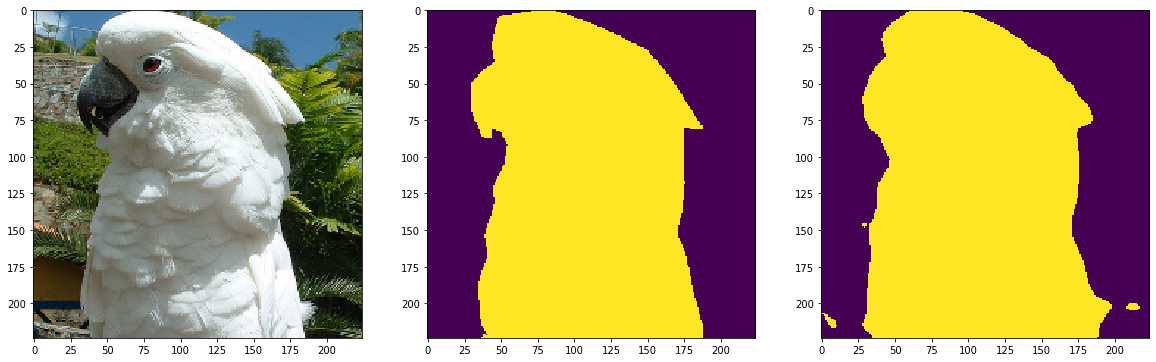

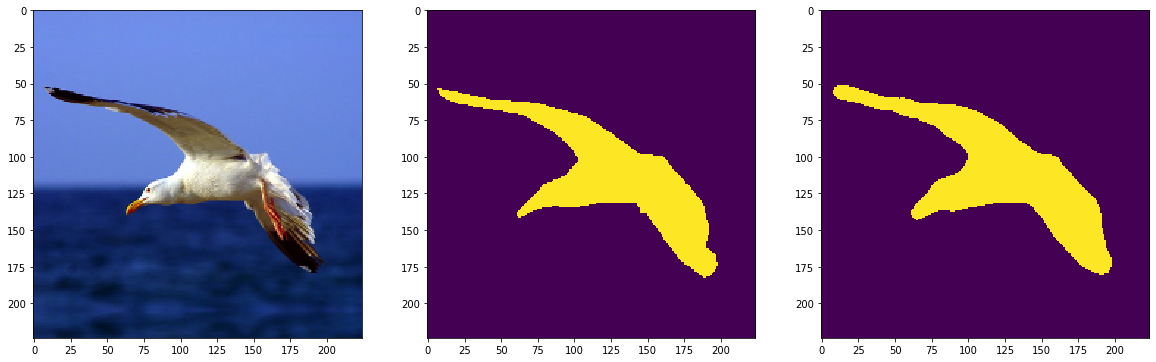

In [178]:
plot_val(555)
plot_val(47)

# cat     

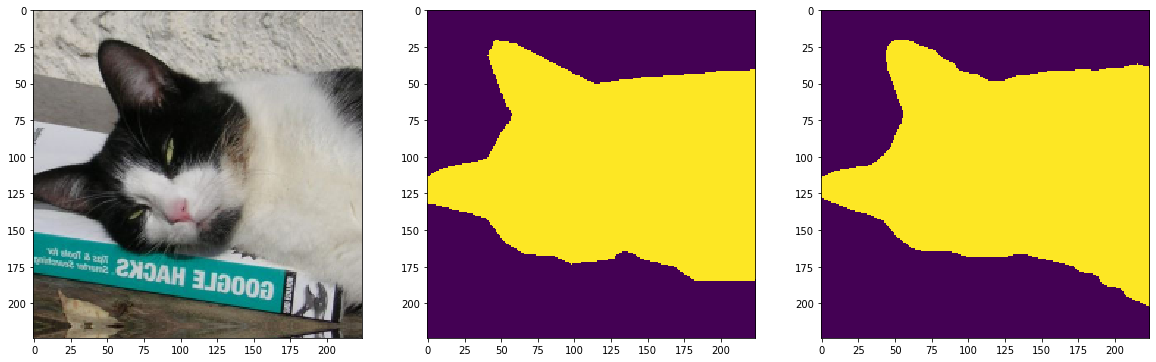

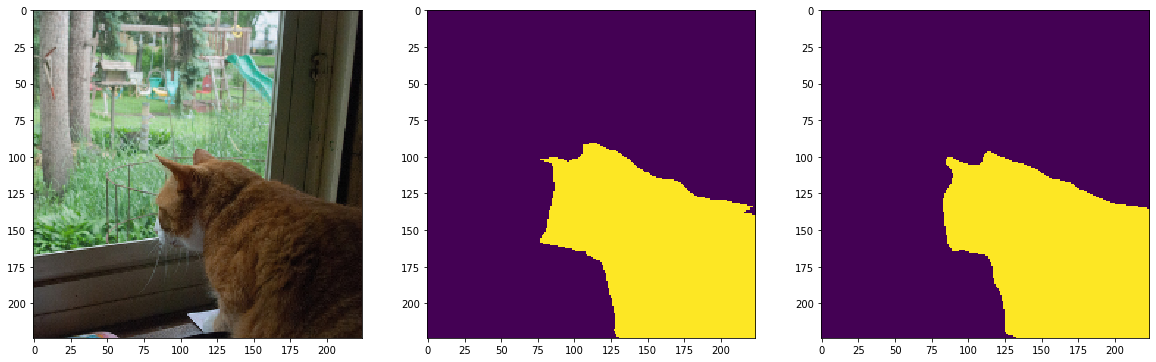

In [184]:
plot_val(8)
plot_val(82)

# dog    

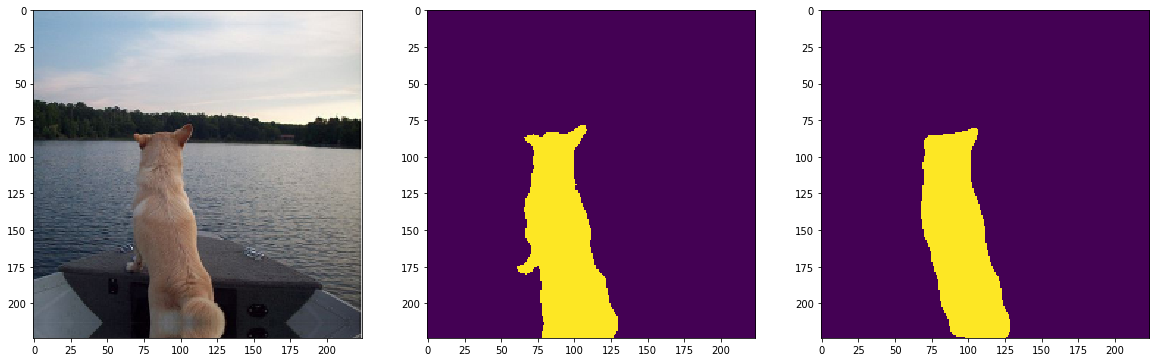

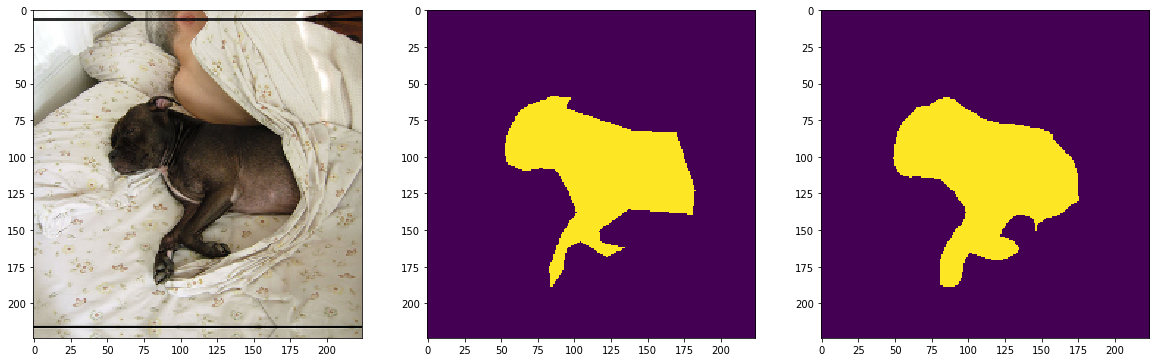

In [185]:
plot_val(15)
plot_val(2)

# horse   

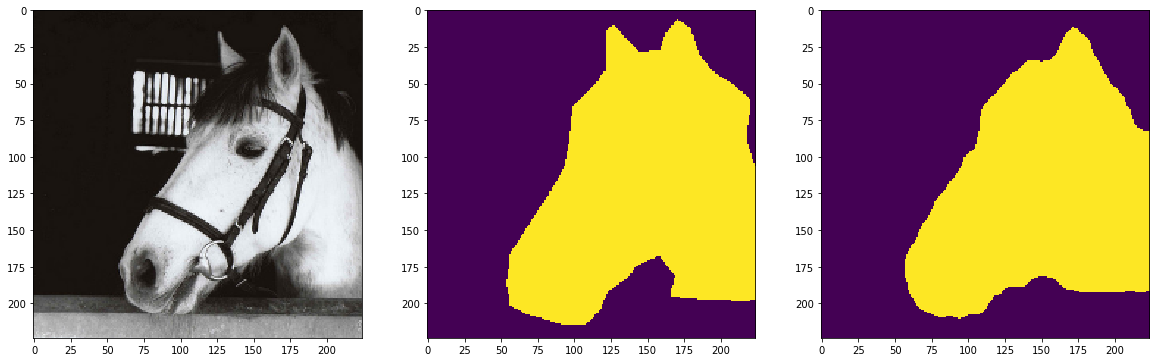

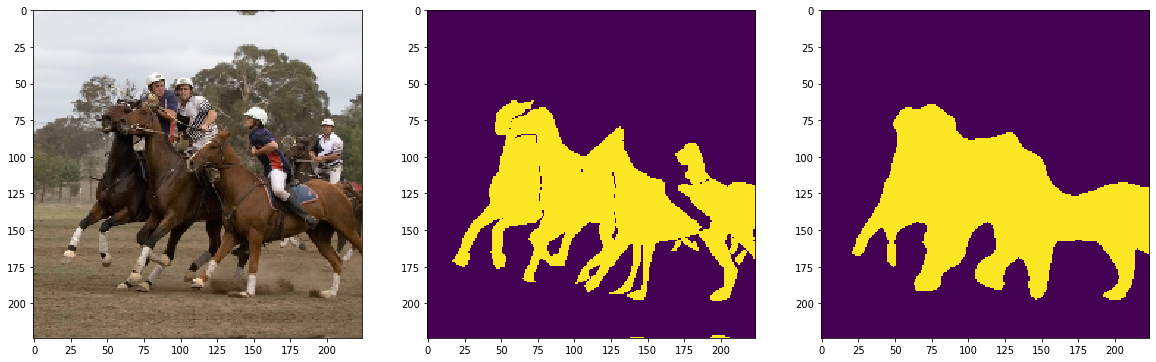

In [186]:
plot_val(17)
plot_val(11)

# sheep   

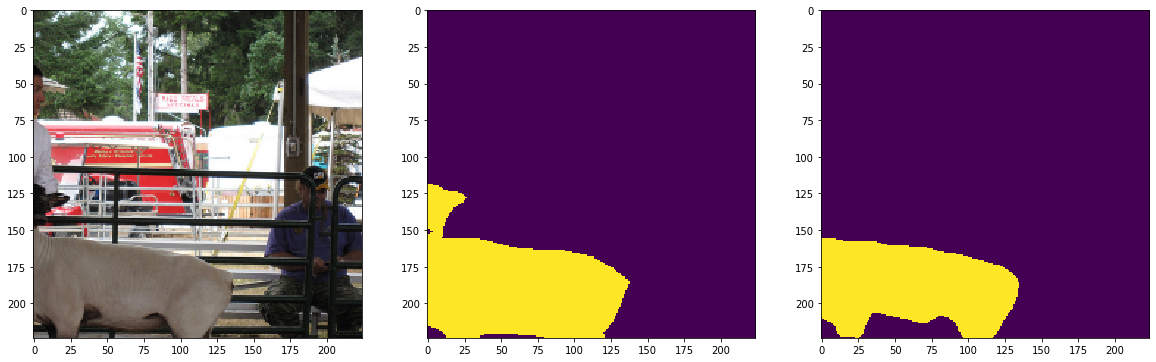

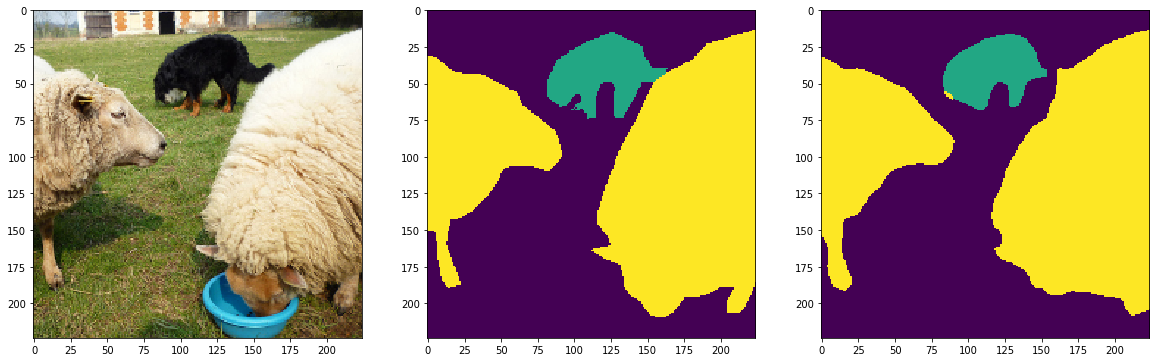

In [190]:
plot_val(4)
plot_val(81)

# cow     

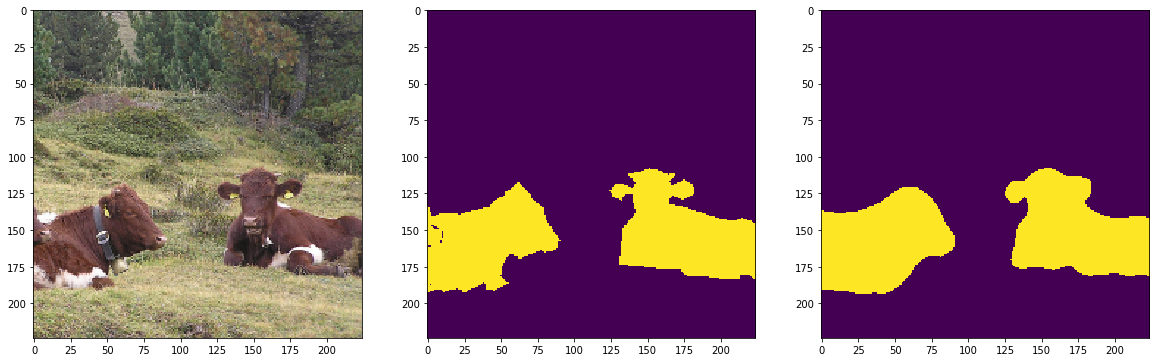

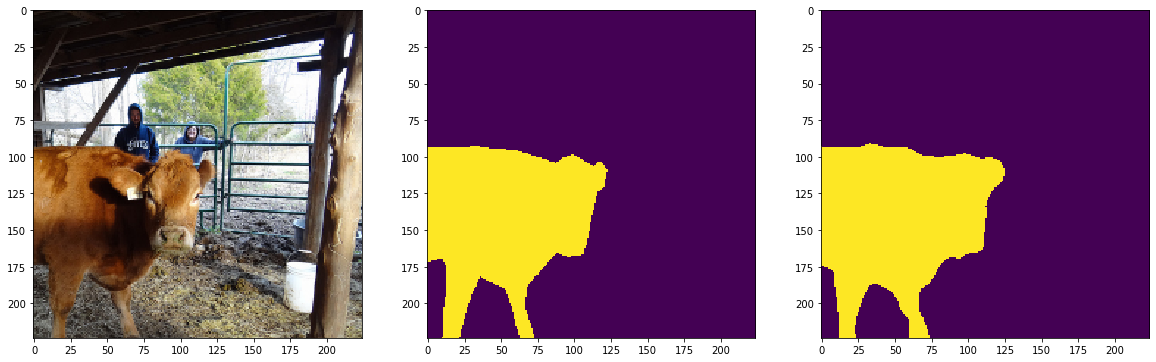

In [191]:
plot_val(75)
plot_val(88)

# elephant

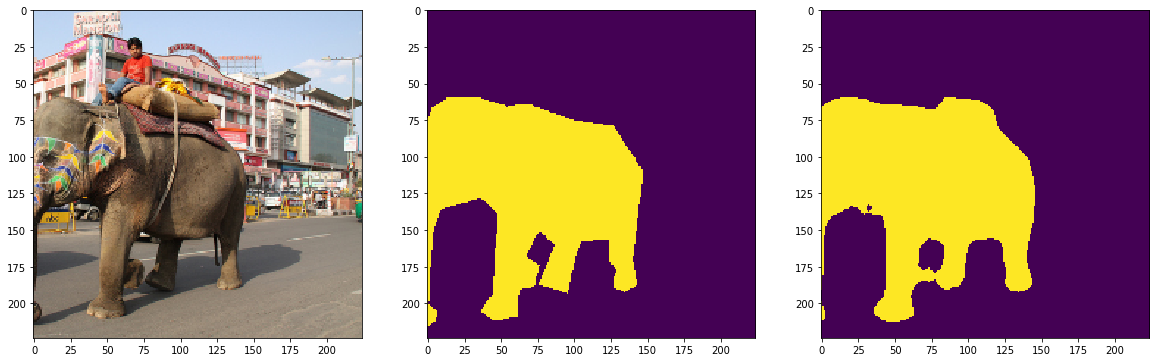

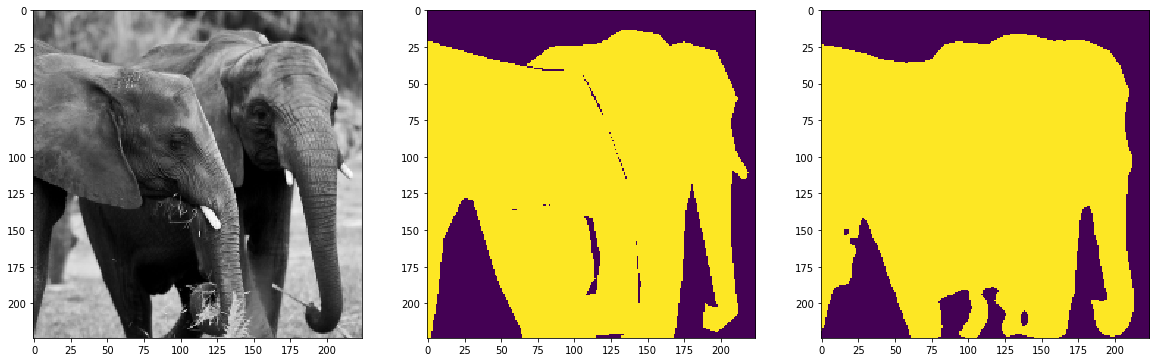

In [192]:
plot_val(19)
plot_val(24)

# bear    

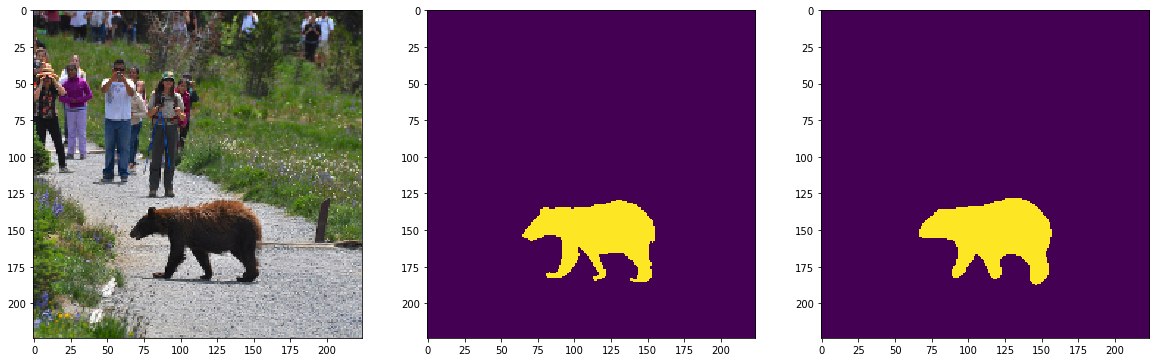

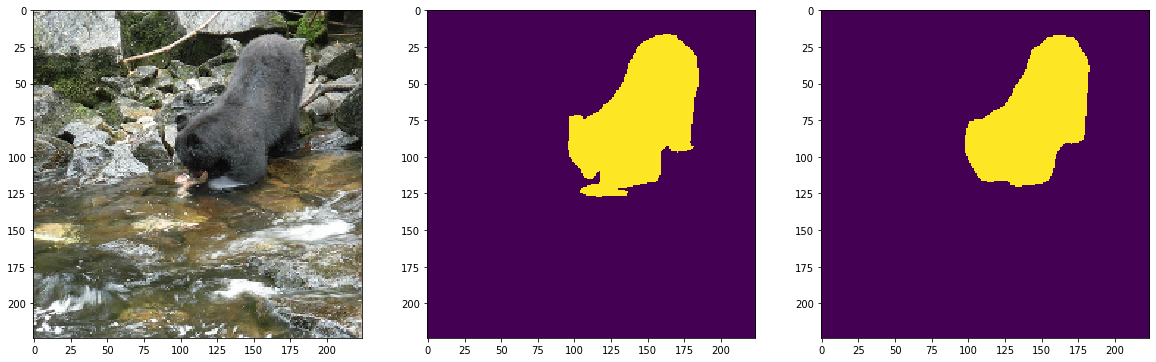

In [193]:
plot_val(13)
plot_val(60)

# zebra   

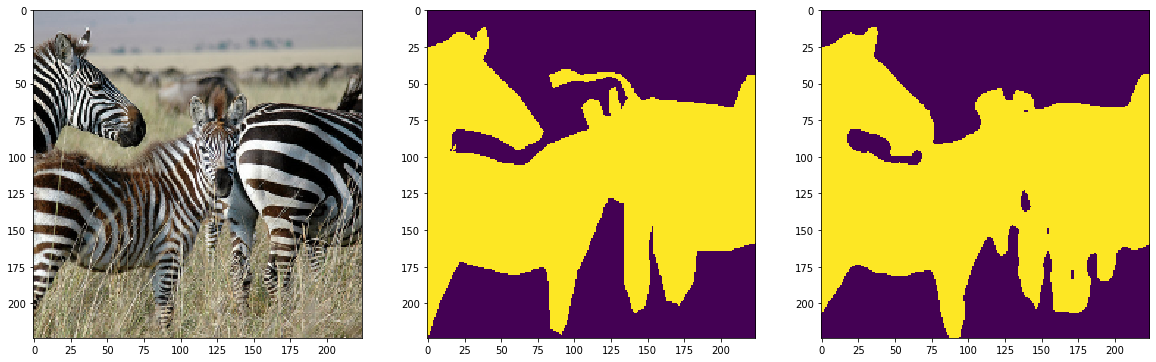

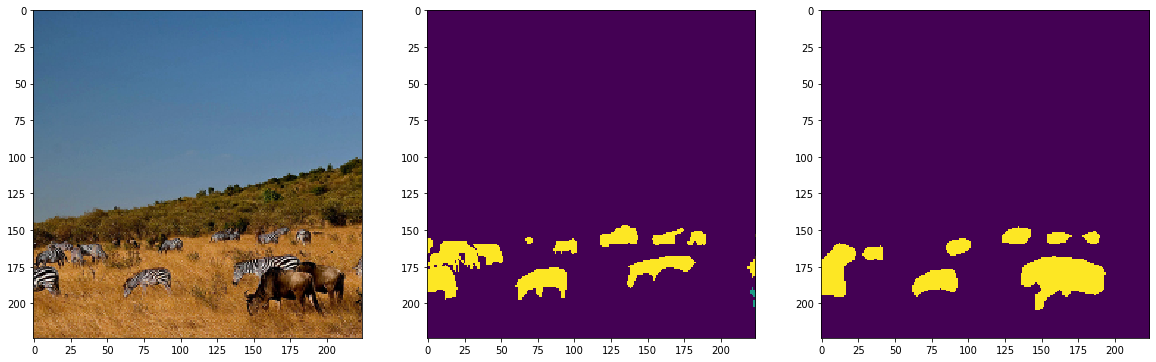

In [194]:
plot_val(30)
plot_val(33)

# giraffe

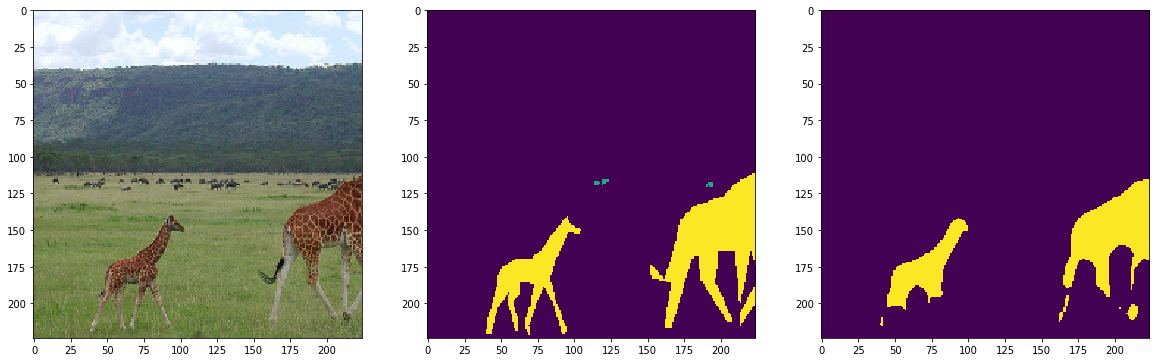

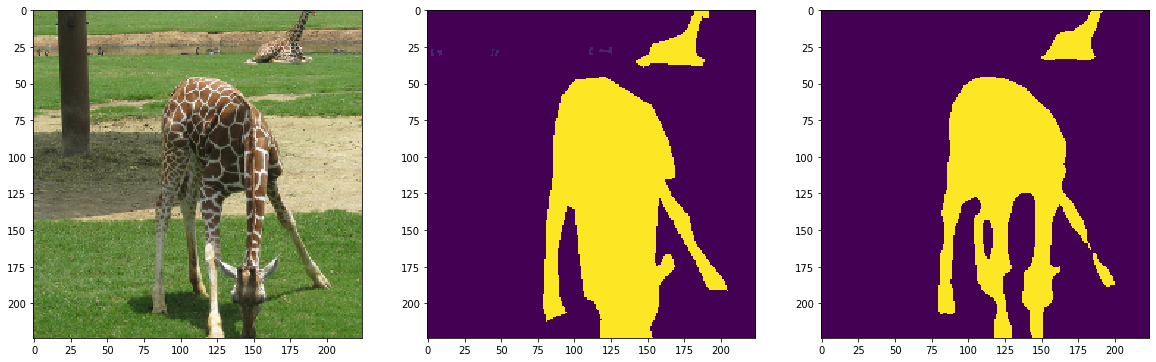

In [195]:
plot_val(5)
plot_val(9)

# Слишком сложное

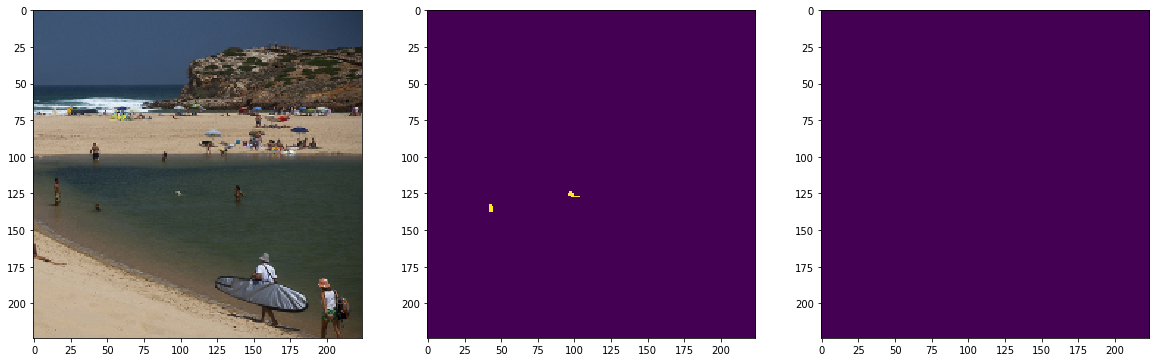

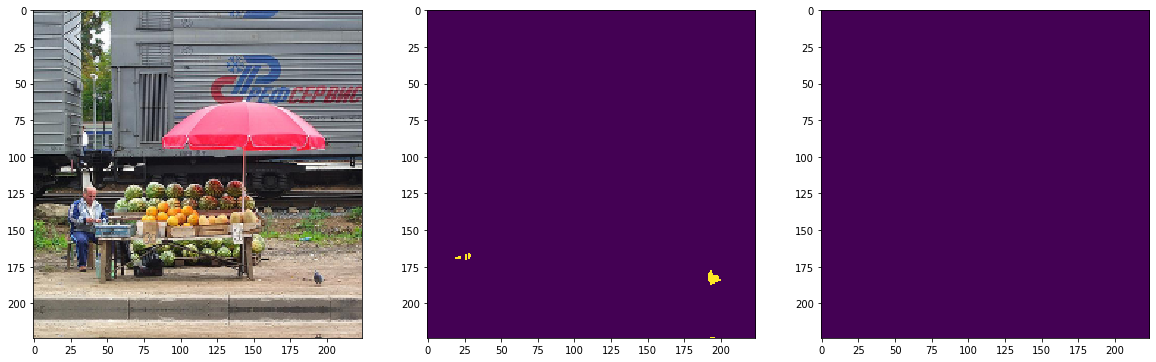

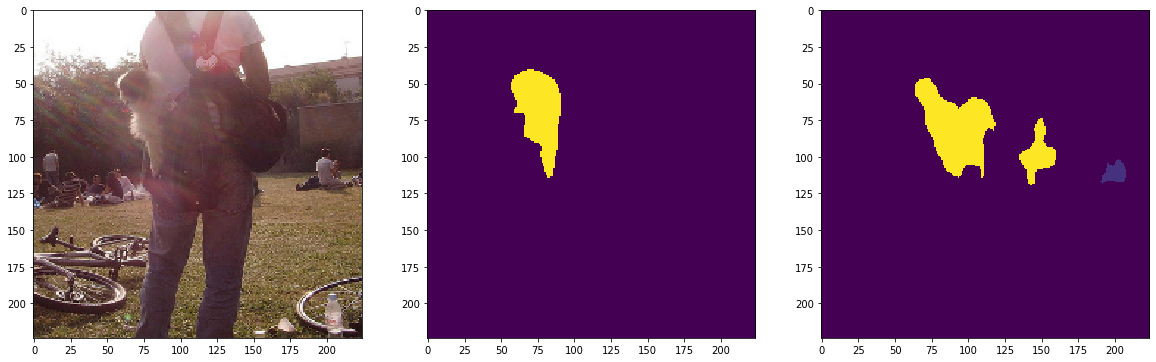

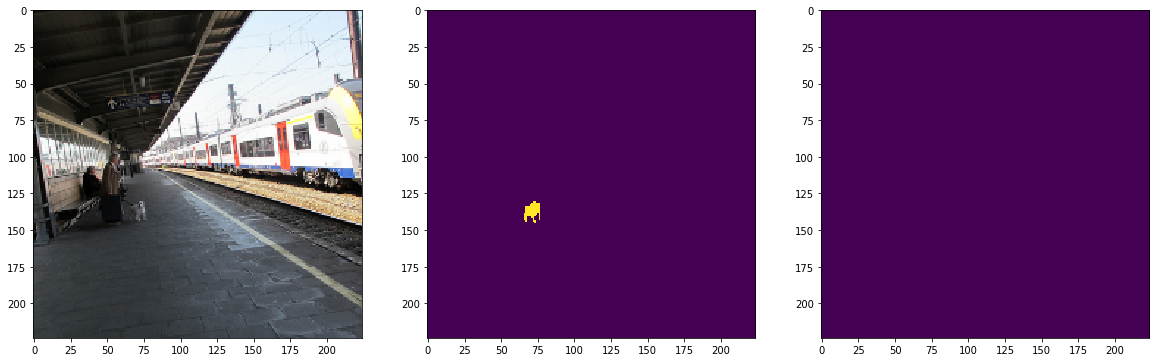

In [196]:
plot_val(41)
plot_val(42)
plot_val(74)
plot_val(98)

# Несколько классов

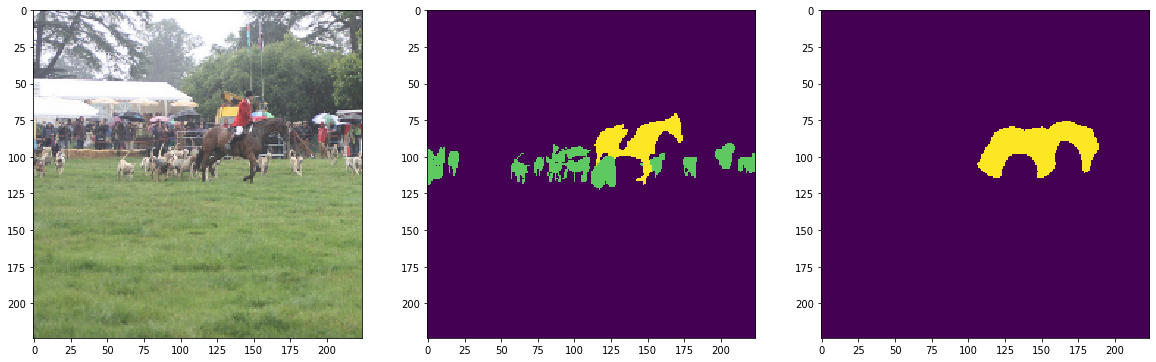

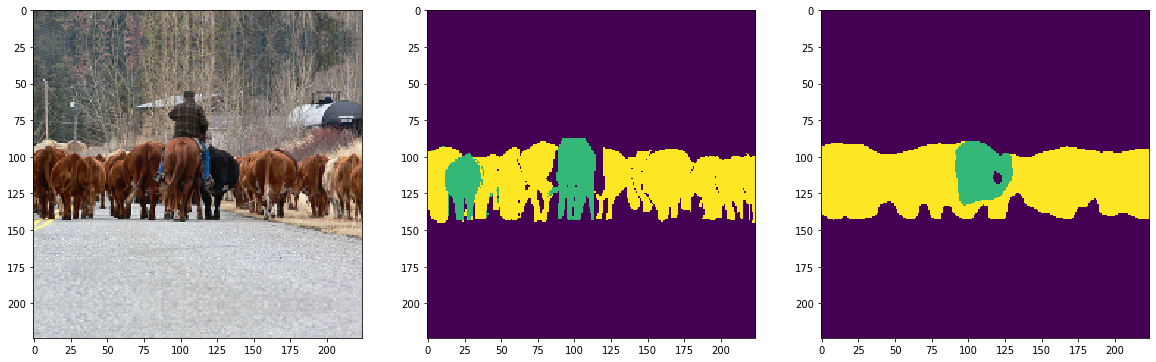

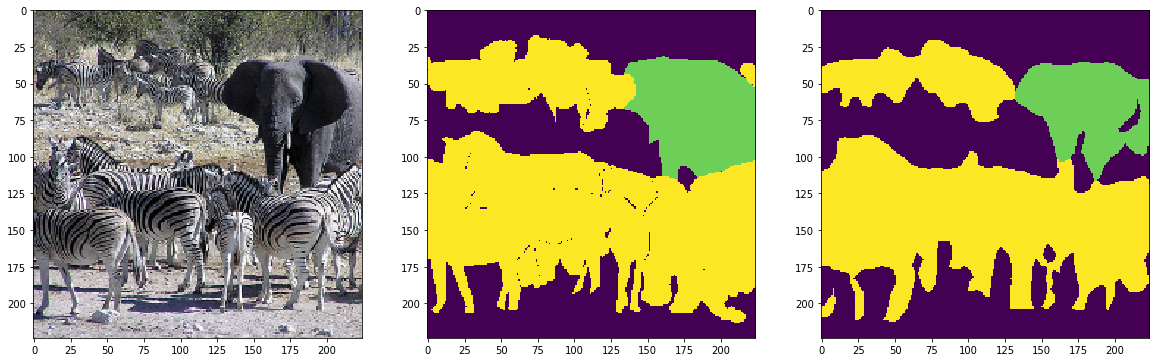

In [197]:
plot_val(57)
plot_val(12)
plot_val(70)